In [43]:
import pandas as pd
import numpy as np
import pickle
import os


from sklearn.metrics import make_scorer, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score
from sklearn.model_selection import TunedThresholdClassifierCV


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import importlib
import scripts.variables as var
import playsound


def play_done_message():
    playsound.playsound("./data/MamaDoIt.mp3")


importlib.reload(var)


print('DONE')

DONE


In [2]:
#Functions
def custom_score(y_test, predictions, fp_cost=1, fn_cost=1):
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    return fn*fn_cost + fp * fp_cost

def custom_score_fn_doubled(y_test, predictions, fp_cost=1, fn_cost=2):
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    return fn*fn_cost + fp * fp_cost

# Goal.
> Once you selected your model, what about to incorporate the cost? What if I am able (a HUGE if) to measure the cost of errors? I will estate this: the cost of missing a "yes" (client that will contract the term deposit) is double (2) compared to the cost of calling a client that would not contract the product (1).

In [3]:
with open ('model_pickled.pkl','rb') as MODEL:
    data_to_save=pickle.load(MODEL)

In [4]:
pipeline, X_test, y_test,X_train,y_train, cv=data_to_save
old_preds=pipeline.predict(X_test)

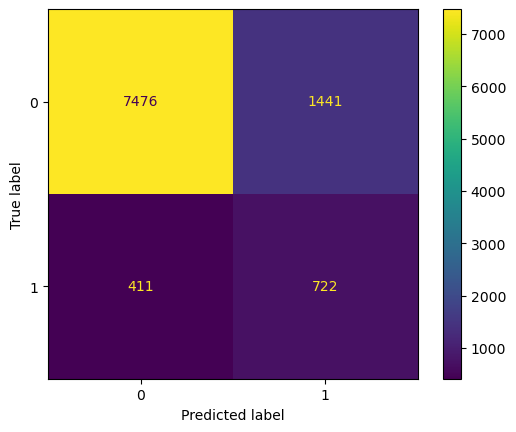

In [5]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

## The cost when errors have the same weight

In [6]:
#let's evaluate the Falses Positives and Negatives
#Being the cost of FP and FN the same and TP and TN having no cost at all
tn, fp, fn, tp = confusion_matrix(y_test,old_preds).ravel() 
print('Cost: ', custom_score(y_test, old_preds))

Cost:  1852


### What the cost would be if we do fn=2 and fp=1?

In [8]:
old_cost=custom_score(y_test,old_preds,fn_cost=2)
print(f'The cost is {old_cost} if we assume that the cost of False Negatives is 2 versus 1 of False Positives')

The cost is 2263 if we assume that the cost of False Negatives is 2 versus 1 of False Positives


### Let's use TunedThreshold Classifier to calculate new thresholds and therefore new predictions and cost

In [10]:
custom_scorer = make_scorer(
    custom_score_fn_doubled, response_method="predict", greater_is_better=False
)
tuned_classifier = TunedThresholdClassifierCV(
    pipeline, cv=cv, scoring=custom_scorer, random_state=2012
).fit(X_train, y_train)
new_cost=custom_score(y_test, tuned_classifier.predict(X_test),fn_cost=2)
new_cutoff=tuned_classifier.best_threshold_
new_preds=tuned_classifier.predict(X_test)
print(f"Tuned decision threshold: {new_cutoff:.3f}")
print(f"Custom score: {new_cost:.2f}")

Tuned decision threshold: 0.803
Custom score: 1788.00


In [12]:
print(f'If with the same model I decide to change the probability cutoff from 0.5 (standard) to {new_cutoff:.3f}, my cost goes down to {custom_score(y_test, new_preds,fn_cost=2):.2f}')
print(f"This is a {(old_cost-new_cost)/old_cost*100:.2f}% reduction")

If with the same model I decide to change the probability cutoff from 0.5 (standard) to 0.803, my cost goes down to 1788.00
This is a 20.99% reduction


In [13]:
print("I will first calculate the probabilities with the old model")
predictions=[]
standard_cutoff=0.5
for prob in pipeline.predict_proba(X_test):
    if prob[1]>standard_cutoff:
        predictions.append(1)
    else:
        predictions.append(0)
custom_score(y_test,predictions, fn_cost=2)
print(f"As you can see I get the same  old cost ({old_cost}) than before: {custom_score(y_test,predictions, fn_cost=2)}")

I will first calculate the probabilities with the old model
As you can see I get the same  old cost (2263) than before: 2263


In [24]:
print("I will now calculate the probabilities with the new cutoff")
predictions=[]

for prob in tuned_classifier.predict_proba(X_test):
    if prob[1]>new_cutoff:
        predictions.append(1)
    else:
        predictions.append(0)
print(f"As you can see I get a similar new cost ({new_cost}) than before: {custom_score(y_test,predictions, fn_cost=2)}")

I will now calculate the probabilities with the new cutoff
As you can see I get a similar new cost (1788) than before: 1788


### It does prove that the tunedthreshold classifier just recalculates the threshold based in a cost function. Although, it implies a change in predictions.

Nest Steps:
1. Analyze distribution 1/0.
2. Impact in accuracy and recall, precision and f1 score

In [23]:
print(f'This is the distribution in 1/0 before changing cutoff is \n {pd.Series(old_preds).value_counts(normalize=True)}')
print(f'This is the distribution in 1/0 after changing cutoff is \n {pd.Series(new_preds).value_counts(normalize=True)}')

This is the distribution in 1/0 before changing cutoff is 
 0    0.784776
1    0.215224
Name: proportion, dtype: float64
This is the distribution in 1/0 after changing cutoff is 
 0    0.913532
1    0.086468
Name: proportion, dtype: float64


* Changing the cutoff to 80% implies to predict more zeros.
* Let's go over accuracy and recall

In [48]:
#Change in accuracy
print(f'Accuracy moves from {accuracy_score(y_test,old_preds)*100:.2f}% to {accuracy_score(y_test,new_preds)*100:.2f}%')
print(f'Recall instead falls down considerably from {recall_score(y_test,old_preds)*100:.2f}% to {recall_score(y_test,new_preds)*100:.2f}%')
print(f'Precision improves significantly going from {precision_score(y_test,old_preds)*100:.2f}% to {precision_score(y_test,new_preds)*100:.2f}%')
print(f'While f1 score does not move much from {f1_score(y_test,old_preds)*100:.2f}% to {f1_score(y_test,new_preds)*100:.2f}%')


Accuracy moves from 81.57% to 89.01%
Recall instead falls down considerably from 63.72% to 39.63%
Precision improves significantly going from 33.38% to 51.67%
While f1 score does not move much from 43.81% to 44.86%
